# Chapter: Dimension Reduction and Latent Variable Methods (Part 1)


# Topic: Process Monitoring using PLS

In [20]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          train PLS model
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [2]:
# import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

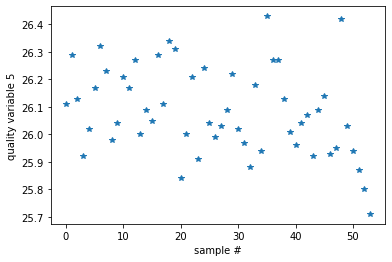

In [4]:
# fetch data
data = pd.read_csv('LDPE.csv', usecols = range(1,20)).values
data_train = data[:-4,:] # exclude last 4 samples

# plot quality variables
quality_var = 5

plt.figure()
plt.plot(data[:,13+quality_var], '*')
plt.xlabel('sample #')
plt.ylabel('quality variable ' + str(quality_var))
plt.show()

In [5]:
# scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_train_normal = scaler.fit_transform(data_train)

In [7]:
# build PLS model
from sklearn.cross_decomposition import PLSRegression

X_train_normal = data_train_normal[:,:-5]
Y_train_normal = data_train_normal[:,-5:]

pls = PLSRegression(n_components = 3)
pls.fit(X_train_normal, Y_train_normal)

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

In [8]:
# compute X and Y variance captured
from sklearn.metrics import r2_score

print('Y variance captured: ', 100*pls.score(X_train_normal, Y_train_normal), '%')

Tscores = pls.x_scores_
X_train_normal_reconstruct = np.dot(Tscores, pls.x_loadings_.T) 
# can also use ls.inverse_transform(Tscores)

print('X variance captured: ', 100*r2_score(X_train_normal, X_train_normal_reconstruct), '%')

Y variance captured:  89.90616771156913 %
X variance captured:  56.034097079808554 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


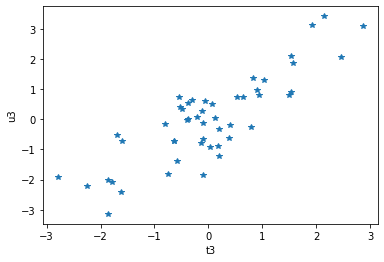

In [9]:
# visualize t vs u
Tscores = pls.x_scores_
Uscores = pls.y_scores_

comp = 3
plt.figure()
plt.plot(Tscores[:,comp-1], Uscores[:,comp-1], '*')
plt.xlabel('t{0}'.format(comp))
plt.ylabel('u{0}'.format(comp))
plt.show()

In [10]:
# monitoring indices for training data
# T2
T_cov = np.cov(Tscores.T)
T_cov_inv = np.linalg.inv(T_cov)

T2_train = np.zeros((data_train_normal.shape[0],))

for i in range(data_train_normal.shape[0]):
    T2_train[i] = np.dot(np.dot(Tscores[i,:],T_cov_inv),Tscores[i,:].T)

# SPEx
x_error_train = X_train_normal - X_train_normal_reconstruct
SPEx_train = np.sum(x_error_train*x_error_train, axis = 1)

# SPEy
y_error_train = Y_train_normal - pls.predict(X_train_normal)
SPEy_train = np.sum(y_error_train*y_error_train, axis = 1)


In [11]:
# control limits
#T2
import scipy.stats

N = data_train_normal.shape[0]
k = 3

alpha = 0.01 # 99% control limit
T2_CL = k*(N**2-1)*scipy.stats.f.ppf(1-alpha,k,N-k)/(N*(N-k))

#SPEx
mean_SPEx_train = np.mean(SPEx_train)
var_SPEx_train = np.var(SPEx_train)

g = var_SPEx_train/(2*mean_SPEx_train)
h = 2*mean_SPEx_train**2/var_SPEx_train
SPEx_CL = g*scipy.stats.chi2.ppf(1-alpha, h)

#SPEy
mean_SPEy_train = np.mean(SPEy_train)
var_SPEy_train = np.var(SPEy_train)

g = var_SPEy_train/(2*mean_SPEy_train)
h = 2*mean_SPEy_train**2/var_SPEy_train
SPEy_CL = g*scipy.stats.chi2.ppf(1-alpha, h)

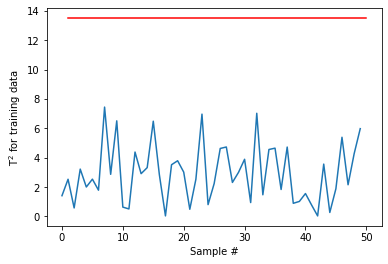

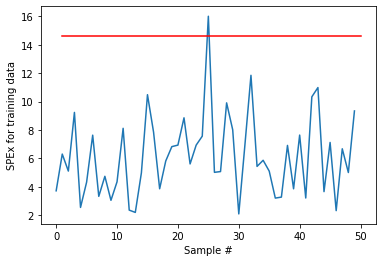

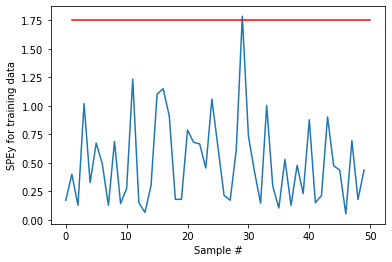

In [12]:
# monitoring charts
# T2_train plot with CL
plt.figure()
plt.plot(T2_train)
plt.plot([1,len(T2_train)],[T2_CL,T2_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('T$^2$ for training data')
plt.show()

# SPEx plot with CL
plt.figure()
plt.plot(SPEx_train)
plt.plot([1,len(SPEx_train)],[SPEx_CL,SPEx_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('SPEx for training data')
plt.show()
         
# SPEy plot with CL
plt.figure()
plt.plot(SPEy_train)
plt.plot([1,len(SPEy_train)],[SPEy_CL,SPEy_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('SPEy for training data')
plt.show()

In [21]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          fault detection on complete data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [13]:
# get test data, normalize it
data_normal = scaler.transform(data)
X_normal = data_normal[:,:-5]
Y_normal = data_normal[:,-5:]

In [14]:
# get model predictions 
Tscores_test = pls.transform(X_normal)
X_normal_reconstruct = np.dot(Tscores_test, pls.x_loadings_.T)
Y_normal_pred = pls.predict(X_normal)

In [15]:
# compute monitoring statistics
T2_test = np.zeros((data_normal.shape[0],))
for i in range(data_normal.shape[0]):
    T2_test[i] = np.dot(np.dot(Tscores_test[i,:],T_cov_inv),Tscores_test[i,:].T)

x_error_test = X_normal - X_normal_reconstruct
SPEx_test = np.sum(x_error_test*x_error_test, axis = 1)

y_error_test = Y_normal - pls.predict(X_normal)
SPEy_test = np.sum(y_error_test*y_error_test, axis = 1)

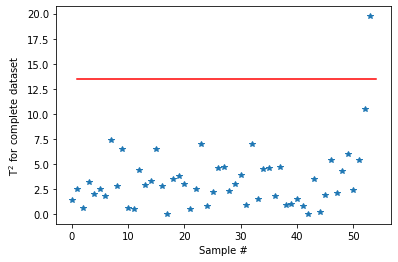

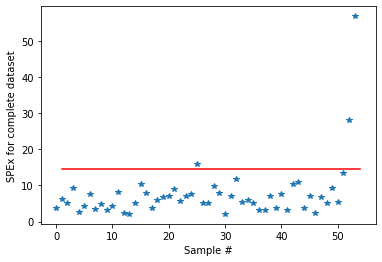

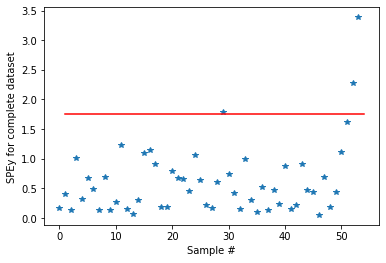

In [16]:
# plot
plt.figure()
plt.plot(T2_test, '*')
plt.plot([1,len(T2_test)],[T2_CL,T2_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('T$^2$ for complete dataset')
plt.show()

plt.figure()
plt.plot(SPEx_test, '*')
plt.plot([1,len(SPEx_test)],[SPEx_CL,SPEx_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('SPEx for complete dataset')
plt.show()

plt.figure()
plt.plot(SPEy_test, '*')
plt.plot([1,len(SPEy_test)],[SPEy_CL,SPEy_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('SPEy for complete dataset')
plt.show()
